In [1]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.images.shape)
print(digits.keys())

import numpy as np
import pylab as plt

from sklearn.metrics import accuracy_score


(1797, 8, 8)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


### Part 0


These are the digits you were asked to classify with  the solutions. 

- What is your accuracy?
- Did it improve after you saw some of the other images?
- What are the digits a human is most likely to mislabel?

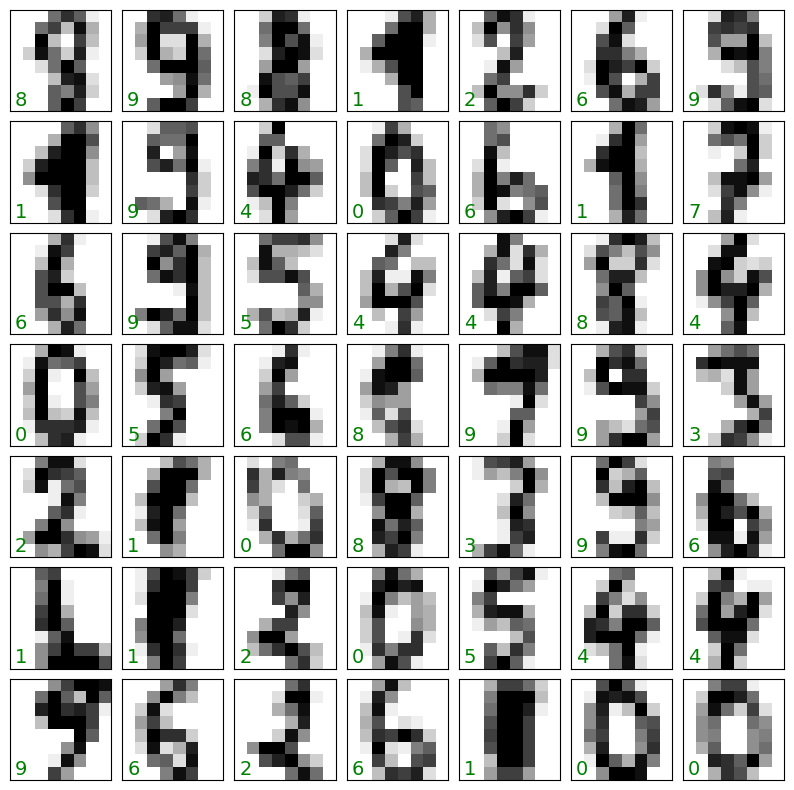

In [2]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(4321) #### This was the seed
mychoices = np.random.choice(digits.images.shape[0],49)
np.random.seed()

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

### Part 1: Unsupervised, dimensionality reduction

In [3]:
np.random.seed(42)

In [4]:
digits.data.shape

(1797, 64)

In [5]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
data_projected = iso.fit_transform(digits.data)
data_projected.shape

/Users/dgerosa/box/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/dgerosa/box/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(1797, 2)

`Isomap` has turned our $1797\times 64$ dimensional data set into a $1797\times 2$ dimensional data set. This is much easier to visualize! Now let's see if that visualization is at all helpful.

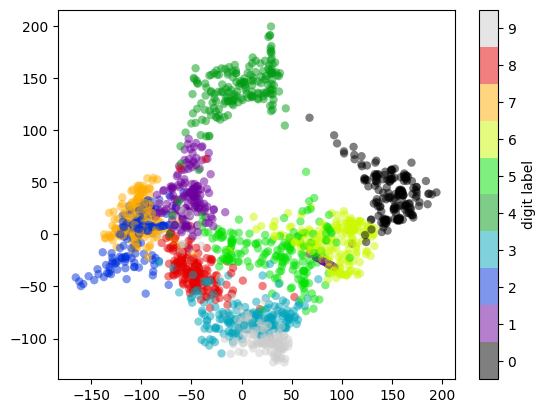

In [6]:
#From: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.colormaps[base_cmap]
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


# Plot all of the data points in the two projected dimensions.  
# Color the points by their labels.
plt.scatter(data_projected[:,0], data_projected[:,1], 
            c=digits.target, edgecolor='none', alpha=0.5, 
            cmap=discrete_cmap(10,'nipy_spectral'));

# Add the color bar
plt.colorbar(label='digit label', ticks=range(10))

# Make it clear which color goes with which label
plt.clim(-0.5, 9.5)

Oh that's nice. We see here that the digits are fairly well-separated in the parameter space. This tells us that a supervised classification algorithm should perform fairly well.

### Part 3: Supervised, classification

Here I'm classifing the full 64-dimensional dataset. I'm not using the dimensionality reduction above. Did you use it istead? How do things change? 

In [9]:
from sklearn.model_selection import train_test_split

# taking 80% of the data as a training set
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, 
                                                random_state=2, train_size=0.8)
print(Xtrain.shape, Xtest.shape)

(1437, 64) (360, 64)


In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=2000,solver='sag')
clf.fit(Xtrain, ytrain)


LogisticRegression(max_iter=2000, solver='sag')

In [ ]:
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

In [12]:
ypredtrain = clf.predict(Xtrain)
accuracy_score(ytrain, ypredtrain)

1.0

[[31  0  0  0  1  0  0  0  0  0]
 [ 0 41  0  1  0  0  0  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  1  1  0]
 [ 0  0  0  0 31  0  0  0  3  1]
 [ 0  1  0  0  1 41  0  0  0  0]
 [ 0  1  0  0  0  0 33  0  1  0]
 [ 0  0  0  0  0  0  0 39  0  1]
 [ 0  0  0  0  0  0  0  0 35  1]
 [ 0  0  0  1  0  1  0  0  1 25]]


/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_7054/1585811182.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(confusion_matrix(ytest, ypred)),


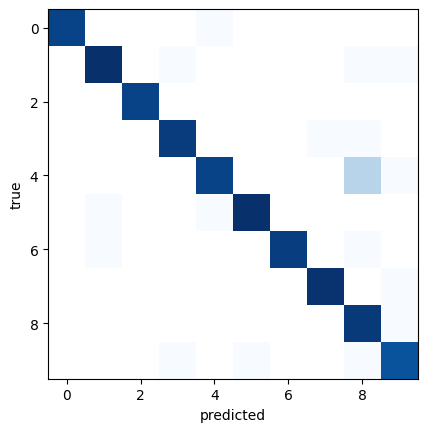

In [14]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, ypred))
plt.imshow(np.log(confusion_matrix(ytest, ypred)), 
           cmap='Blues', interpolation='nearest');
plt.ylabel('true')
plt.xlabel('predicted');

- So, that's $31$ "$0$"s were classified as "$0$", while one of them was classified as a "$4$", and no non-zero digits were so classified.


- $41$ "$1$"s were classified correctly, but one each were classified as a "$3$", "$8$", and "$9$".


- Moreover, one "$5$" and one "$6$" were classified as "$1$"s.


- And so on.


We can look at some of the outputs along with their predicted labels, making the bad labels red:

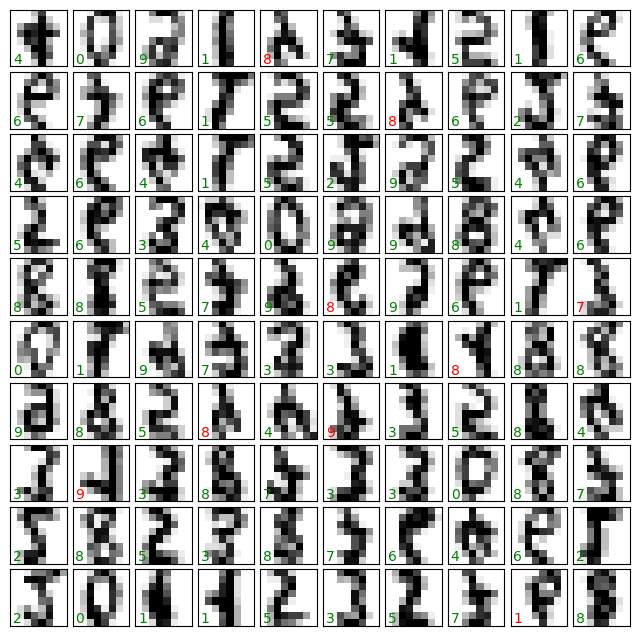

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flipud(Xtest[i].reshape(8, 8)), cmap='binary')
    ax.text(0.05, 0.05, str(ypred[i]), transform=ax.transAxes, 
            color='green' if (ytest[i] == ypred[i]) else 'red')
    ax.set_xticks([])
    ax.set_yticks([])

The interesting thing is that even with this simple logistic regression algorithm, some of the mislabeled cases are ones that we ourselves might get wrong!



### Performance on the dataset above

In [16]:
predchoice = clf.predict(digits.data[mychoices])
confusion_matrix(digits.target[mychoices], predchoice)

array([[6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 7, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 8]])

This is misleading (or maybe just wrong) because I'm not keeping track whether those specific images ended up in the training or test set (probably a mixture of both so, yeah, this is wrong). 

If you want to properly compare your manual classification against that of a machine, you should set this up such that all the images in `mychoice` are in the test set. Give it a go! 